## Generate CCI data cubes - Permafrost
### A DeepESDL example notebook 

This notebook demonstrates how to access CCI data via the dedicated xcube store, which provides dynamic data cube views into each gridded data set. More information on the data sets offered can be found in the [Open Data Portal](https://climate.esa.int/en/odp/#/dashboard) of the [ESA Climate Change Initiative](https://climate.esa.int/en/esa-climate/esa-cci/) (CCI).

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/user-guide/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

### Combined Permafrost Dataset (L4, Multi-Sensor, Multi-Platform, Ground Temperature & Freezing/Thawing Rate)

This notebook generates a dataset which combines multiple permafrost monitoring datasets, integrating data from different sources, models, and platforms. It includes both Ground Temperature (GTD) and Permafrost Freezing/Thawing Rate (PFR) at a yearly level (L4). The temperature and thawing/freezing data are derived from MODIS Land Surface Temperature (LST) combined with two different processing approaches: bias-corrected ERA5 climate reanalysis and the CryoGrid model.


Brockmann Consult, 2025


In [1]:
# mandatory imports
from xcube.core.store import new_data_store
from xcube.core.chunk import chunk_dataset

# Utilities for notebook visualization
import shapely.geometry
from IPython.display import JSON
import matplotlib.pyplot as plt
import s3fs
import pyproj
import os
from datetime import datetime

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,8

In [3]:
import xcube_cci

Provide mandatory parameters to instantiate the store class:

In [4]:
store = new_data_store('cciodp')
store

/home/conda/alicebalfanz/88ecd51084bac98812dc7f2b4037ed7a911bee77f4ce880822f695127e15c10f-20250304-154909-336672-700-xcube-1.8.3-xcube-cci/lib/python3.10/abc.py:106: FutureWarning: xarray subclass VectorDataCube should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


The cube will be stored into the team s3 storage, for this the necessary information is stored in the environmen variables.

In [5]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

We want to modify the attributes of the variables as well as the chunking of the output dataset, for this we have the below functions. 

In [6]:
def modify_attrs(ds, new_attrs, delete_attrs):
    ds = ds.assign_attrs(new_attrs)
    if delete_attrs:
        for attr_to_be_del in delete_attrs:
            ds.attrs.pop(attr_to_be_del, None) 
    return ds

Please adjust the output_id according to your needs: 

In [25]:
output_id = 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr'

In [8]:
attrs_for_cube = {'date_created': datetime.today().strftime('%Y-%m-%d'),
                  'id': output_id,
                  'project': 'DeepESDL',
                  'time_coverage_end': '2019-07-02T12:00:00',
                  'time_coverage_start': '2000-07-02T12:00:00',
                  'source': f'esacci.PERMAFROST.yr.L4.GTD.multi-sensor.multi-platform.ERA5_MODISLST_BIASCORRECTED.03-0.r1, esacci.PERMAFROST.yr.L4.GTD.multi-sensor.multi-platform.MODISLST_CRYOGRID.03-0.r1, esacci.PERMAFROST.yr.L4.PFR.multi-sensor.multi-platform.ERA5_MODISLST_BIASCORRECTED.03-0.r1, esacci.PERMAFROST.yr.L4.PFR.multi-sensor.multi-platform.MODISLST_CRYOGRID.03-0.r1',
                  'title': 'ESA CCI PERMAFROST', 
                  'description': 'Combined Permafrost Dataset (L4, Multi-Sensor, Multi-Platform, Ground Temperature & Freezing/Thawing Rate). This dataset combines multiple permafrost monitoring datasets. It includes both Ground Temperature (GTD) and Permafrost Freezing/Thawing Rate (PFR) at a yearly level (L4). The temperature and thawing/freezing data are derived from MODIS Land Surface Temperature (LST) combined with two different processing approaches: bias-corrected ERA5 climate reanalysis and the CryoGrid model.'}

In [9]:
attrs_for_vars = {"valid_max" : 100,
                  "valid_min" : -100, 
                  "color_value_min": -30, 
                  "color_value_max": 30,
                  "color_bar_name": "coolwarm",
                  "grid_mapping": "spatial_ref"}

In [10]:
attrs_for_PFR_vars = {"valid_max" : 100,
                      "valid_min" : 0, 
                      "color_value_min": 0, 
                      "color_value_max": 100,
                      "color_bar_name": "plasma",
                      "grid_mapping": "spatial_ref",
                      "gcmd_keyword_url":"https://gcmd.earthdata.nasa.gov/KeywordViewer/scheme/Earth%20Science/c82f3480-545f-4491-83f1-0477369ddcd8?gtm_keyword=PERMAFROST&gtm_scheme=Earth%20Science"}

In [11]:
attrs_to_be_del = ['conversion',
                   'actual_max',
                   'actual_min',
                   'data_type',
                   'shape',
                   'fill_value',
                   'size',
                   'chunk_sizes',
                   'chunks',
                   'preferred_chunks'
                   'dimensions',
                   'file_chunk_sizes',
                   'file_dimensions'] 

In [12]:
time_chunking = 1 # timestamps per chunk
y_chunking = 1151 # lat/y values per chunk
x_chunking = 1641 # lon/x values per chunk

Due to the cci odp api causing trouble when requesting large datasets, we will split the cube build in steps by years. Unfortunatly xcube is not ready to do so yet, so we need a workaround:

In [13]:
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=False, 
                       key=S3_USER_STORAGE_KEY,
                       secret=S3_USER_STORAGE_SECRET)

In [14]:
s3_client_kwargs = {'endpoint_url': "https://s3.eu-central-1.amazonaws.com"}
target_bucket_path = f"s3://{S3_USER_STORAGE_BUCKET}"

In [15]:
target_bucket_path

's3://hub-deepesdl2'

In [24]:
start_year = 2002
end_year = 2020 # you need to adjust accordingly if you wish to create a shorter time range

Please note, that for the Permafrost case we have the first two years derived from ERA5 and then the remaining years from MODIS. Furthermore, the dataset saving upon creation is slightly different than when in append mode. 

In [17]:
gcmd_keyword_url = {"GST" : "https://gcmd.earthdata.nasa.gov/KeywordViewer/scheme/Earth%20Science/d559b900-eca6-42a4-9311-0297b2ef98ab?gtm_keyword=LAND%20SURFACE%20TEMPERATURE&gtm_scheme=Earth%20Science",
                    "T": "https://gcmd.earthdata.nasa.gov/KeywordViewer/scheme/Earth%20Science/021714ad-1cae-441c-bb6f-4be866a0f742?gtm_keyword=SOIL%20TEMPERATURE&gtm_scheme=Earth%20Science"}


In [18]:
first_time_slice = True
mapper = fs.get_mapper(f'{target_bucket_path}/{output_id}')
for t in range(start_year, end_year):
    start_run_time = datetime.now()
    print(t)
    if first_time_slice:
        print("Frist Time Slice")
        ds = store.open_data('esacci.PERMAFROST.yr.L4.GTD.multi-sensor.multi-platform.ERA5_MODISLST_BIASCORRECTED.03-0.r1',
                             time_range=['2000-01-01','2002-12-31'])
        ds_p = store.open_data('esacci.PERMAFROST.yr.L4.PFR.multi-sensor.multi-platform.ERA5_MODISLST_BIASCORRECTED.03-0.r1',
                          time_range=['2000-01-01','2002-12-31'])
        ds = ds.merge(ds_p)
    else:
        ds = store.open_data('esacci.PERMAFROST.yr.L4.GTD.multi-sensor.multi-platform.MODISLST_CRYOGRID.03-0.r1',
                             time_range=[f'{t}-01-01',f'{t}-12-31'])
        ds_p = store.open_data('esacci.PERMAFROST.yr.L4.PFR.multi-sensor.multi-platform.MODISLST_CRYOGRID.03-0.r1',
                          time_range=[f'{t}-01-01',f'{t}-12-31'])              
        ds = ds.merge(ds_p)

    for var_name in ds.data_vars:
        if var_name != "polar_stereographic":
            if var_name == "PFR":
                attrs_for_PFR_vars["long_name"]=f'{var_name} {ds[var_name].attrs["standard_name"].replace("_", " ")}'
                ds[var_name] = modify_attrs(ds[var_name], attrs_for_PFR_vars, attrs_to_be_del)
            else:
                attrs_for_vars["long_name"]=f'{var_name} {ds[var_name].attrs["standard_name"].replace("_", " ")}'
                ds[var_name] = modify_attrs(ds[var_name], attrs_for_vars, attrs_to_be_del)
                if var_name == "GST":
                    ds[var_name] = ds[var_name].assign_attrs(gcmd_keyword_url=gcmd_keyword_url[var_name])
                else:
                    ds[var_name] = ds[var_name].assign_attrs(gcmd_keyword_url=gcmd_keyword_url["T"])
                
    ds = modify_attrs(ds, attrs_for_cube, None)
    ds["polar_stereographic"] = ds.polar_stereographic.assign_attrs(pyproj.CRS("EPSG:3995").to_cf())
    ds = ds.rename_vars({'polar_stereographic': 'spatial_ref'})
    vars_encoding = {k: dict(write_empty_chunks=False) for k, v in ds.data_vars.items() if k != "spatial_ref"} 
    ds = chunk_dataset(ds,{'time': time_chunking, 'y': y_chunking, 'x': x_chunking})
    if first_time_slice:
        print("Frist Time Slice")
        ds.to_zarr(mapper, mode='w', consolidated=True, encoding=vars_encoding)
        print(f'finished creating first time slice')
        first_time_slice = False
    else:
        ds.to_zarr(mapper, mode='a', append_dim='time', consolidated=True)    
        print(f'finished appending {t}')
        ds.close()
    print(f'Took:  {datetime.now() - start_run_time}')  

2002
Frist Time Slice
Frist Time Slice
finished creating first time slice
Took:  0:25:05.448034


Once it is done, you can investigate the newly created dataset from your team storage

In [19]:
team_store = new_data_store("s3", 
                            root=S3_USER_STORAGE_BUCKET, 
                            storage_options=dict(anon=False,
                                                 key=S3_USER_STORAGE_KEY, 
                                                 secret=S3_USER_STORAGE_SECRET))

In [21]:
ds = team_store.open_data(output_id)

In [22]:
ds

<xarray.Dataset> Size: 20GB
Dimensions:      (time: 3, y: 10353, x: 14762, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 24B 2000-07-02 ... 2002-07-02T12:00:00
    time_bnds    (time, bnds) datetime64[ns] 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
  * x            (x) float64 118kB -6.111e+06 -6.111e+06 ... 7.566e+06 7.566e+06
  * y            (y) float64 83kB 4.115e+06 4.114e+06 ... -5.477e+06 -5.478e+06
Dimensions without coordinates: bnds
Data variables:
    GST          (time, y, x) float64 4GB dask.array<chunksize=(1, 1151, 1641), meta=np.ndarray>
    PFR          (time, y, x) float32 2GB dask.array<chunksize=(1, 1151, 1641), meta=np.ndarray>
    T10m         (time, y, x) float64 4GB dask.array<chunksize=(1, 1151, 1641), meta=np.ndarray>
    T1m          (time, y, x) float64 4GB dask.array<chunksize=(1, 1151, 1641), meta=np.ndarray>
    T2m          (time, y, x) float64 4GB dask.array<chunksize=(1, 1151, 1641), meta=np.ndarray>
    T5m          (time, y, x) float64 4GB dask.array<chunksize=(1, 1151, 1641), meta=np.ndarray>
    spatial_ref  float64 8B ...
Attributes:
    Conventions:             CF-1.7
    date_created:            2025-03-06
    description:             Combined Permafrost Dataset (L4, Multi-Sensor, M...
    history:                 [{'cube_params': {'time_range': ['2000-01-01T00:...
    id:                      esa-cci-permafrost-1x1151x1641-0.8.0.zarr
    processing_level:        L4
    project:                 DeepESDL
    source:                  esacci.PERMAFROST.yr.L4.GTD.multi-sensor.multi-p...
    time_coverage_duration:  P1096DT0H0M0S
    time_coverage_end:       2019-07-02T12:00:00
    time_coverage_start:     2000-07-02T12:00:00
    title:                   ESA CCI PERMAFROST

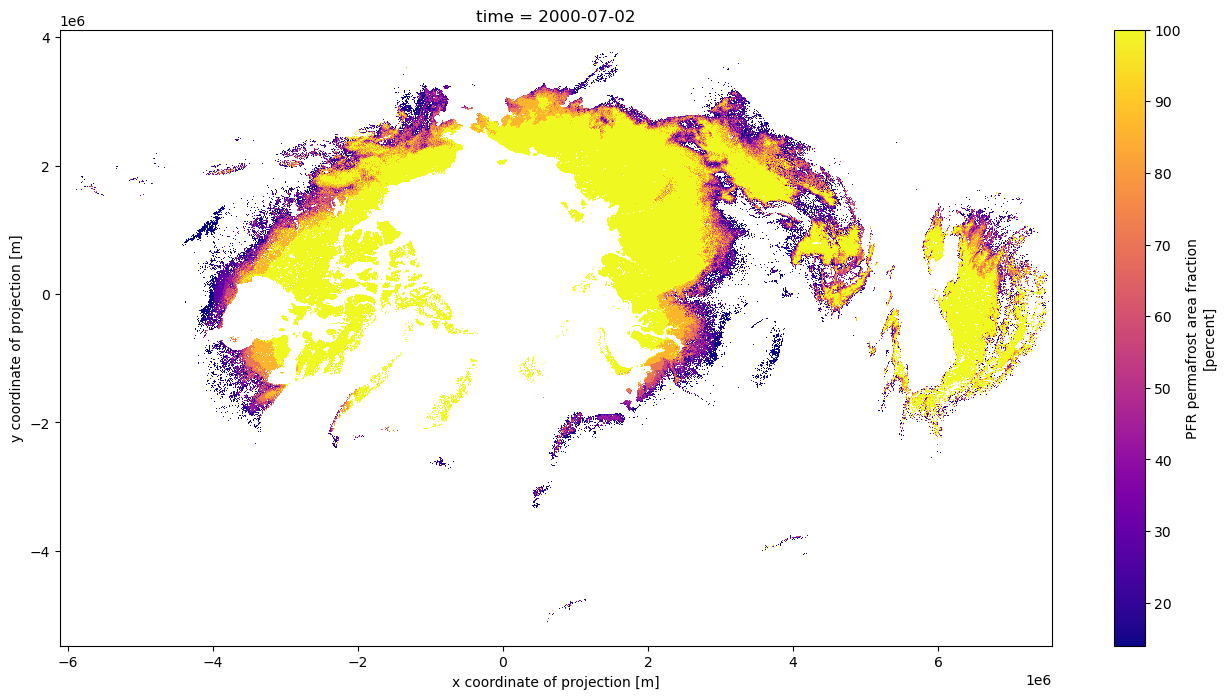

In [23]:
ds.PFR.isel(time=0).plot.imshow(cmap='plasma')